## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute camera calibration using chessboard images(Doing once)

In [35]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
i=0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)        
        cv2.waitKey(5)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)   

cv2.destroyAllWindows()
print ("Camera Calibrated")

Camera Calibrated


## Using camera calibration output

In [1]:
#This cell to use camera calibration data without regenerating them each time
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython import display
from random import randint
from skimage import img_as_ubyte
import pickle

%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

#print (mtx)
mtx=np.float32([[  1.15396093e+03 ,  0.00000000e+00  , 6.69705359e+02]
 ,[  0.00000000e+00 ,  1.14802495e+03  , 3.85656232e+02]
 ,[  0.00000000e+00 ,  0.00000000e+00  , 1.00000000e+00]])
print (mtx)
print("--------------")

#print (dist)
dist=np.float32([[ -2.41017968e-01 , -5.30720497e-02 , -1.15810318e-03 , -1.28318544e-04
,    2.67124303e-02]])
print (dist)
print("--------------")



[[  1.15396094e+03   0.00000000e+00   6.69705383e+02]
 [  0.00000000e+00   1.14802490e+03   3.85656219e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
--------------
[[ -2.41017967e-01  -5.30720502e-02  -1.15810323e-03  -1.28318541e-04
    2.67124306e-02]]
--------------


## Apply a distortion correction to raw images

In [2]:
from IPython import display
import glob
import matplotlib.image as mpimg



def undistort(img):
    undistorted = cv2.undistort(img,mtx,dist,None,mtx)
    return undistorted

# for img in glob.glob("./test_images/*.jpg"):
#     image= cv2.imread(img)
#     undistorted = undistort(image)
#     plt.imshow(image)
#     display.display(plt.gcf())
#     plt.imshow(undistorted)
#     display.display(plt.gcf())


## Create a thresholded binary image

In [3]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt

sobel_kernel_size = 9
sx_thresh = (20, 100)
mag_thresh = (170, 230)
dir_thresh=(0.7, 1.2)
sy_thresh = (65, 150)


def colorConvert (img):
# Convert to HSV color space
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    return hsv


def abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=255):    
    if(orient=='x'):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif(orient=='y'):
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output    

def mag_threshold(img, sobel_kernel, thresh): # thresh_min=100 , thresh_max=10):      
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    abs_sobel = np.sqrt(abs_sobelx*abs_sobelx+abs_sobely*abs_sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    binary_output = np.zeros_like(scaled_sobel) # Create a binary mask where mag thresholds are met
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <=thresh[1])] = 1    
    return binary_output

def dir_threshold(img, sobel_kernel, thresh):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx) 
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1       
    return binary_output



def get_compined3(ff, ksize, mag_thresh, sx_thresh, sy_thresh , dir_thresh):
    image = ff[:,:,2]
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=sx_thresh[0], thresh_max=sx_thresh[1])# thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=sy_thresh[0], thresh_max=sy_thresh[1]) #thresh_min=65, thresh_max=150)
    mag_binary = mag_threshold(image, sobel_kernel=ksize,thresh=mag_thresh) #thresh_min=170 ,thresh_max=255)#20
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh) #(0.7, 1.2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) & ((mag_binary == 1) | (dir_binary == 1))] = 1
    return combined

# image_input = mpimg.imread('test_images/test1.jpg')

# image_undistorted= undistort(image_input)
# hsv = colorConvert (image_undistorted)
# binaryImage = get_compined3(hsv, sobel_kernel_size, mag_thresh, sx_thresh,sy_thresh,dir_thresh)
# plt.imshow(image_input)
# display.display(plt.gcf())
# plt.imshow(hsv)
# display.display(plt.gcf())
# plt.imshow(binaryImage)

print("done")

done


## Apply a perspective transform to rectify binary image ("birds-eye view").

In [13]:
from skimage import img_as_ubyte

def unwarp(img):
    src_leftlowerpoint  = [203, 720]
    src_leftupperpoint  = [585, 460]
    src_rightlowerpoint = [1127, 720]
    src_rightupperpoint = [695, 460]

    dst_leftlowerpoint  = [260,680]
    dst_leftupperpoint  = [200,0]
    dst_rightlowerpoint = [960, 720]
    dst_rightupperpoint = [960, 0]
    
    src  =[[203, 720],[585, 460], [1127, 720], [695, 460]]
    dst= [[260,680], [200,0], [960, 720],[960, 0]]
    src = np.float32(src)
    dst = np.float32(dst)

    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img_as_ubyte(warped), M

print("done")

done


## Detect lane pixels and fit to find the lane boundary.

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_histogram(img):
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    return histogram

def fit(top_down,histogram):
    out_img = np.dstack((top_down, top_down, top_down))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(top_down.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = top_down.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#    print("nonzero,nonzerox,nonzeroy",nonzero,nonzerox,nonzeroy)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = top_down.shape[0] - (window+1)*window_height
        win_y_high = top_down.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#    print("Curvature",left_curverad, 'm', right_curverad, 'm')

    
    
    return out_img ,left_fitx, right_fitx, ploty ,left_curverad,right_curverad

## Determine the curvature of the lane and vehicle position with respect to center.


In [26]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def compute_position(top_down,left_fitx,right_fitx,left_curverad,right_curverad):
# Compute car position
    m_car = top_down.shape[1] / 2
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of xm_per_pixcurvature is in meters
    avg_radius = np.mean([left_curverad, right_curverad])
    return offset_right_from_center ,avg_radius

#     out_img ,left_fitx, right_fitx, ploty ,left_curverad,right_curverad=fit(top_down,histogram)
#     #out_img ,left_fitx, right_fitx, ploty=fit_2_lanes(top_down,histogram)
#     final_output = draw_lane(image_read, out_img, perspective_M, left_fitx, right_fitx, ploty)
#     offset_right_from_center ,avg_radius=compute_position(top_down,left_fitx,left_curverad,right_curverad)


##  Warp the detected lane boundaries back onto the original image.


In [27]:
def draw_lane(image, warped, M, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

##  Main pipeine


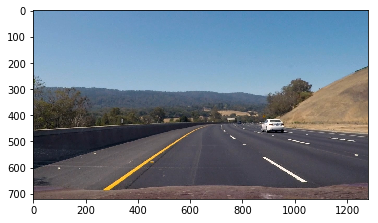

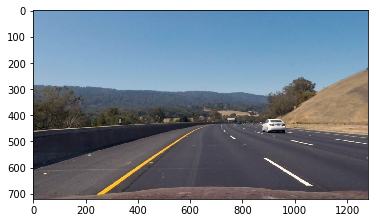

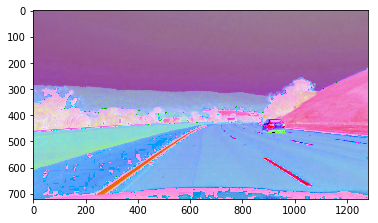

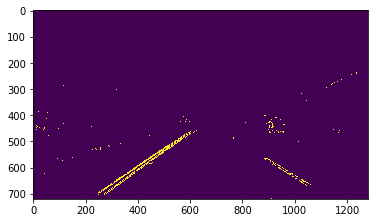

C:\Users\MahmoudK\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


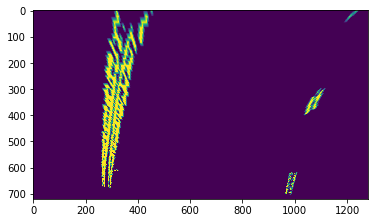

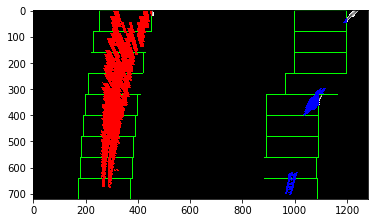

834.152369433 0.853845368841


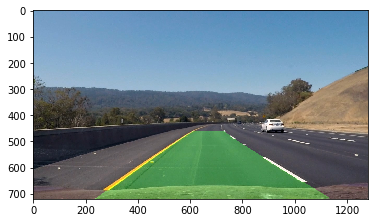

In [31]:
# #print (image_read.shape)
def main_pipeline(image_read):
#     plt.imshow(image_read) 
#     display.display(plt.gcf())
    #lines_edges,edges=get_prespective_src(image_read)
    image_undistorted= undistort(image_read)
#     plt.imshow(image_undistorted)   
#     display.display(plt.gcf())
    image = colorConvert(image_undistorted)
#     plt.imshow(image)   
#     display.display(plt.gcf())
    compined=get_compined3(image, sobel_kernel_size, mag_thresh, sx_thresh,sy_thresh,dir_thresh)
#     plt.imshow(compined)   
#     display.display(plt.gcf())
    top_down, perspective_M = unwarp(compined)

#     plt.imshow(top_down)
#     display.display(plt.gcf())
    #print (edges,edges[0])
    histogram = get_histogram(top_down)
    out_img ,left_fitx, right_fitx, ploty, radius , offset=fit(top_down,histogram)
    #out_img ,left_fitx, right_fitx, ploty=fit_2_lanes(top_down,histogram)
    final_output = draw_lane(image_read, out_img, perspective_M, left_fitx, right_fitx, ploty)
#     plt.imshow(final_output)
    return final_output
    
def pipeline(image_read):
    plt.imshow(image_read) 
    display.display(plt.gcf())
    #lines_edges,edges=get_prespective_src(image_read)
    image_undistorted= undistort(image_read)
    plt.imshow(image_undistorted)   
    display.display(plt.gcf())
    image = colorConvert(image_undistorted)
    plt.imshow(image)   
    display.display(plt.gcf())
    compined=get_compined3(image, sobel_kernel_size, mag_thresh, sx_thresh,sy_thresh,dir_thresh)
    plt.imshow(compined)   
    display.display(plt.gcf())
    top_down, perspective_M = unwarp(compined)

    plt.imshow(top_down)
    display.display(plt.gcf())
    #print (edges,edges[0])
    histogram = get_histogram(top_down)
    out_img ,left_fitx, right_fitx, ploty ,left_curverad,right_curverad=fit(top_down,histogram)
    #out_img ,left_fitx, right_fitx, ploty=fit_2_lanes(top_down,histogram)
    final_output = draw_lane(image_read, out_img, perspective_M, left_fitx, right_fitx, ploty)
    offset ,radius=compute_position(top_down,left_fitx,right_fitx,left_curverad,right_curverad)
    #     plt.imshow(final_output)
    return final_output ,out_img,radius , offset   
    
image_read = mpimg.imread('test_images/test3.jpg')
final,out_img , radius , offset=pipeline(image_read)
plt.imshow(out_img)
display.display(plt.gcf())

plt.imshow(final)

print (radius , offset)

##  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = './test_videos_output/project_video.mp4'
clip = VideoFileClip("./project_video.mp4")
challenge_clip = clip.fl_image(main_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4


100%|██████████████████████████████████████████████████████▉| 1260/1261 [13:07<00:00,  1.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video.mp4 

Wall time: 13min 9s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))